# Supplementary material for the paper "Does the Na/Ca-exchanger allow for regenerative calcium entry in thin astrocyte processes?"


*A. R. Brazhe (https://orcid.org/0000-0002-1495-4652), A. Yu. Verisokin (http://orcid.org/0000-0002-3655-7682), D. V. Verveyko (https://orcid.org/0000-0003-3661-3928), D. E. Postnov (https://orcid.org/0000-0002-6575-0975)*



A model of the Na/Ca exchanger, its modulation by cytosolic sodium and calcium, and implications for astrocytic calcium dynamics. The model is based on the Weber et al 2001 model, with added Na-dependent inactivation as a Hodgkin–Huxley-type gating variable.

Reference implementation, simulation and parameter values. Figures from the paper are reproduced. 

In [1]:
%pylab inline
rc('axes',grid=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def hill(x, Kh,n):
    xn = x**n
    return xn/(xn + Kh**n)

def rescale(v):
    return (v-v.min())/(v.max()-v.min())


def simpleaxis(ax,level=1):
    """plot only x and y axis, not a frame for subplot ax"""
    hide = ['top', 'right','bottom', 'left']
    for key in hide:
        ax.spines[key].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    sides = [ax.get_xaxis(),]#ax.get_yaxis()
    if level > 1:
        for t in ax.get_xaxis().get_ticklabels():
            t.set_visible(False)
    if level > 2:
        for t in ax.get_yaxis().get_ticklabels():
            t.set_visible(False)
    if  level > 3:
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

def softmax(x):
    "a simple workaround to avoid dividing by zero"
    return clip(x, 1e-12,x)


In [3]:
F = 96500 # [Coulomb/mole]
R = 8.314 # [J/mole/K]
lab_temperature = 37.0 # Celsius

T = 273.15 + lab_temperature # K
Vastro = -80. # mV

def Encx(ccai,cnai):
    "Reversal potential of NCX, Cna [mM], Cca [uM]"
    ena = Nernst(csf['Na'],cnai)
    eca = Nernst(csf['Ca'],ccai*1e-3,2)
    return 3*ena-2*eca

def Nernst(Cout,Cin,z=1):
    "Nernst potential in mV"
    return 1000.*(R*T/(z*F))*log(Cout/softmax(Cin))  # never divides by zero


# Remember we use [Ca]o in mM and [Ca]i in uM

# Ion concentrations in aCSF and astrocyte cytoplasm [mM]
csf = dict(K=3,Na=145,Ca=1.2,Cl=130)              # Verkhratsky,Nedergaard (2018)
cyt = dict(K=130,Na=16,Ca=75*1e-3,Cl=50)          # Verkhratsky,Nedergaard (2018)

pv3 = 0.0   # uM/s, Max Ca2+ uptake by SERCA? pump
pk3 = 0.1   # uM, Activation constant for Ca2+-pump

ncx_pars = dict(
        eta = 0.35,
        KmCao = 1.3, # mM
        KmNai = 12.3, #mM
        KmCai = 0.0026, #mM
        ksat = 0.25,
        nHill = 2.0,
        KmCaAct=130e-3, # uM
)

ncx_pars['KmNao'] = ncx_pars['KmNai']*(ncx_pars['KmCao']/ncx_pars['KmCai'])**(1/3)

In [4]:
ncx_pars

{'KmCaAct': 0.13,
 'KmCai': 0.0026,
 'KmCao': 1.3,
 'KmNai': 12.3,
 'KmNao': 97.62516469604427,
 'eta': 0.35,
 'ksat': 0.25,
 'nHill': 2.0}

In [5]:
# ---- Na dependence ----
# inactivation by Na+ (Inactivation state I1)
def hinf(Cna,Cca,Kna=5, Kca=0.8,hill_na=2,hill_ca=2):
    u = 1./(1 + (Cca/Kca)**hill_ca)
    return 1 - u*hill(Cna,Kna,hill_na)

def htau(Cca,Kca=1.0,tau0=10,hill=1.0):
    return 0.25+tau0/(1 + (Cca/Kca)**hill)


# ---- Ca dependence (high-affinity)/ release from inactivated state I2 ----
def ninf(Cca, Kca=0.1, H=2):
    return hill(Cca, Kca, H)

In [6]:
def JncxΔE(ccai, cnai, V=Vastro, p=ncx_pars):
    """'Electrochemical' component of the NCX-mediated Ca flux, no allosteric modulation"""
    FoRT = F*1e-3/R/T
    η = p['eta']
    ccai_mM = ccai*1e-3
    cnai3 = cnai**3
    ΔE  = (cnai3*csf['Ca']*exp(η*V*FoRT) - csf['Na']**3*ccai_mM*exp((η-1)*V*FoRT))
    denom = (p['KmCao']*cnai3 + 
             p['KmNao']**3*ccai_mM + 
             p['KmNai']**3*csf['Ca']*(1 + ccai_mM/p['KmCai']) + 
             p['KmCai']*csf['Na']**3*(1+(cnai/p['KmNai'])**3) + 
             cnai3*csf['Ca'] + 
             csf['Na']**3*ccai_mM)*(1 + p['ksat']*exp((η-1)*V*FoRT))
    ΔE = ΔE/denom
    return ΔE

def Jncx(ccai, cnai, h, Jmax=1., V=Vastro, p=ncx_pars):
    "NCX-mediated Ca flux with allosteric modulation"
    ΔE = JncxΔE(ccai,cnai,V,p)
    return Jmax*h*ninf(ccai)*ΔE
   

In [7]:
nav = linspace(0.01,100,250)
cav2 = array([0.01, 0.1, 0.3, 0.5,1.0])

(-0.3, 0.05)

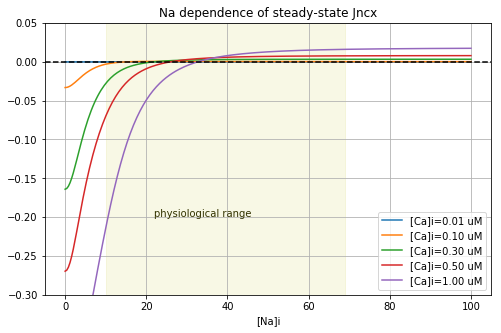

In [8]:
figure(figsize=(8,5))
for ca in cav2:
    plot(nav, Jncx(ca, nav,hinf(nav,ca),V=-70), label='[Ca]i=%0.2f uM'%ca)
    
axhline(0,color='k',ls='--')
legend(fontsize=10)
xlabel('[Na]i')
title('Na dependence of steady-state Jncx')
#xlim(0,5); 
axvspan(10,69,color='y',alpha=0.1,zorder=-100)
text(22, -0.2, 'physiological range',color=(0.2,0.2,0))
ylim(-0.30,0.05)

Text(0.5,1,'Ca dependence of steady-state Jncx')

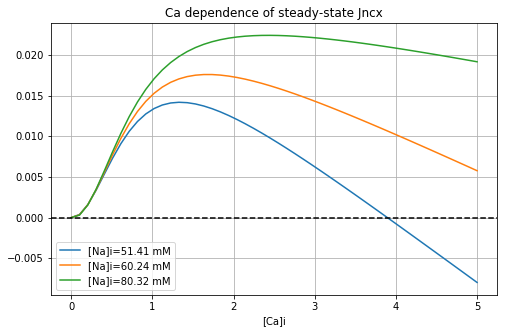

In [9]:
figure(figsize=(8,5))

ki = [128,150,200]
cav = linspace(0.001,5)

for na in nav[ki]:
    plot(cav, Jncx(cav, na, hinf(na,cav),V=-70), label='[Na]i=%0.2f mM'%na)
    
axhline(0,color='k',ls='--')
legend(fontsize=10)
xlabel('[Ca]i')
title('Ca dependence of steady-state Jncx')

## ODE

In this section we integrate point models of the NCX. First, a model where [Na]i is a parameter is used for phaseplane analysis. Next, a model with both Ca and Na as dynamic variables is simulated.

In [10]:
from scipy.interpolate import UnivariateSpline as usp

def adams_bashforth(rhs, init_state, dt=0.25, tstart=0, tstop=500,  fnkwargs=None):
    """Simple function to integrate a set of ODEs
    Inputs:
       rhs : callable, calculates right-hand sides of ODEs
       init_state: initial state as a 1D vector
       dt : fixed time step
       tstart: time at start of integration
       tsopt: integrate until this time
       fnkwargs: dictionary with optional parameters for the rhs function
    """
    if fnkwargs is None:
        fnkwargs = {}
        
    #ndim = len(init_state)
    sh = asarray(init_state).shape
    tv = arange(tstart,tstop,dt)
    xout = zeros((len(tv),)+ sh)
    xout[0] = init_state
    fprev = array(rhs(xout[0], tv[0], **fnkwargs))
    xnew = xout[0] + dt*fprev
    xout[1] = xnew
    for k,t in enumerate(tv[1:-1]):
        xprev,xcurr = xout[k:k+2]
        fnew = array(rhs(xcurr, t,**fnkwargs))
        xnew = xcurr + dt*(3*fnew/2.0 - fprev/2.0)
        fprev = fnew
        xout[k+2] = xnew
    return tv, xout

## Smooth interpolated pulses

def I_pulse(tx, amp, start, stop,k=10):
    "Creates single pulse with given amplitude, start and stop times"
    return amp*0.5*(1 + tanh(k*(tx-start)) * tanh(k*(-tx+stop)))

def make_pulses(tv, npulses=5, period=5, start=100, amp=5, width=1,steep=1.,base=0):
    "Creates a set of pulses for stimulation currents"
    onsets = arange(start, start+npulses*period,period)
    y = base+np.sum(I_pulse(tv, amp-base, on, on+width,k=steep) for on in onsets)
    return usp(tv, y, s=0)


### Model where [Na]i is a parameter: phaseplane

In [11]:
def clamped_na_ncx_w(state,t,jna=lambda t:0, jca=lambda t:0,tau_ex=10.,Jmax=10.,V=Vastro):
    "NCX model with [Ca]i and h (inactivation) as variables"
    ccai,h = state 
    cnai = cyt['Na'] + jna(t)
    jx = Jncx(ccai,cnai,h,Jmax=Jmax,V=V) # current, mediated by NCX
    dca = jca(t) + jx + (cyt['Ca']-ccai)/(tau_ex) 
    dh = (hinf(cnai,ccai)-h)/htau(ccai)
    
    return array([dca,dh])

In [12]:
def ca_nullcline(cca,cna,jbias,tau_ex=10.,Jmax=1,V=Vastro):
    return (-jbias - (cyt['Ca']-cca)/tau_ex)/Jncx(cca,cna,1,Jmax,V)

In [13]:
cav = linspace(0.001,15,1000)
cnav = linspace(5, 150, 10)

cna = 20
cna2 = 50


cyt['Ca'] = 0.075


jca_app = 0.0
pars = dict(Jmax=40, V =-75, tau_ex = 2.)

cav = ma.masked_where(abs(pars['V']-Encx(cav,cna))<0.1,cav)
cav = ma.masked_where(abs(pars['V']-Encx(cav,cna2))<0.1,cav)


init_state = [0.075, 0.4]

tv0, traj0 = adams_bashforth(clamped_na_ncx_w, init_state, dt=0.05,tstop=310, 
                             fnkwargs=dict(jna=lambda t:cna-cyt['Na'],jca=lambda t:0,**pars))

tv1, traj1 = adams_bashforth(clamped_na_ncx_w, [0.6,0.05], dt=0.05,tstop=310, 
                             fnkwargs=dict(jna=lambda t:cna2-cyt['Na'],jca=lambda t:jca_app,**pars))

tv2, traj2 = adams_bashforth(clamped_na_ncx_w, [0.8,0.05], dt=0.05,tstop=310, 
                             fnkwargs=dict(jna=lambda t:cna2-cyt['Na'],jca=lambda t:jca_app,**pars))

Text(0.5,1,'NCX as Ca trigger')

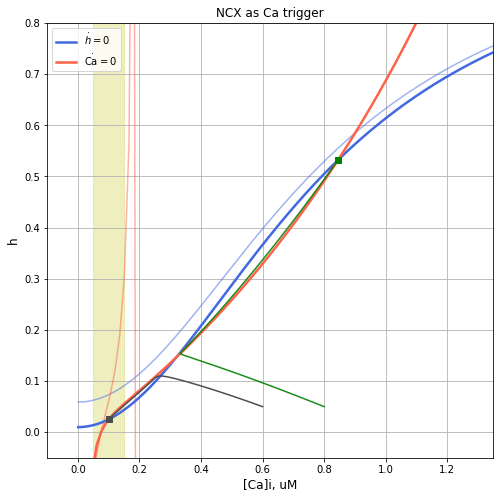

In [14]:
figure(figsize=(8,8))
plot(cav, hinf(cna,cav),color='royalblue', ls='-', label='_$\dot n=0$',alpha=0.5)
plot(cav, ca_nullcline(cav, cna, jca_app,**pars), color='tomato', ls='-',
     alpha=0.5,label='_$\dot \mathrm{Ca}=0$')


plot(cav, hinf(cna2,cav),color='royalblue', label='$\dot h=0$',lw=2.5)
plot(cav, ca_nullcline(cav, cna2, jca_app,**pars),lw=2.5, color='tomato',label='$\dot \mathrm{Ca}=0$')

plot(traj1[:,0],traj1[:,1],'-',color=(0.3,)*3,label='_traj')
plot(traj1[-1,0],traj1[-1,1],'s',color=(0.3,)*3)


plot(traj2[:,0],traj2[:,1],'g-',label='_traj',alpha=0.9)
plot(traj2[-1,0],traj2[-1,1],'gs')

legend(loc=2)

xlabel('[Ca]i, uM',fontsize=12); ylabel('h',fontsize=12)
axvspan(50e-3, 150e-3, alpha=0.25,color='y',zorder=-10)
ylim(-0.05, 0.8)
xlim(-0.1,1.35)
title('NCX as Ca trigger')

### Model with [Na]i and [Ca]i as dynamic variables

In [15]:
def ncx_model(state,t,jna=lambda t:0, jca=lambda t:0, tau_ex=10.,r=1.,Jmax=0.5,V=Vastro,p=ncx_pars):
    "NCX model with [Ca]i,[Na]i and h (Na-dependent inactivation) as variables"
    ccai,cnai, h = state
    j = Jncx(ccai,cnai,h,Jmax=Jmax,V=V,p=p) 
    jnoreg = Jmax*JncxΔE(ccai,cnai,V,p)
    
    jx = (r*j + (1-r)*jnoreg)
    dna = jna(t) + (cyt['Na']-cnai)/(5*tau_ex) - 3*jx
    dca = jca(t) + jx + (cyt['Ca']-ccai)/(tau_ex)
    dh = (hinf(cnai,ccai)-h)/htau(ccai)
    
    return array([dca,dna,dh])

In [16]:
Na_pulse = make_pulses(arange(0,10000,0.2), 1, period=1200, start=100,amp=3.5,width=700,steep=5.,base=0.)
Ca_pulse = make_pulses(arange(0,10000,0.2), 2, period=800, start=350,amp=1.0,width=1.0,steep=5.,base=0.)

In [17]:
pars

{'Jmax': 40, 'V': -75, 'tau_ex': 2.0}

In [18]:
shared_params = dict(jna=Na_pulse,jca=Ca_pulse,tau_ex = 2.0,V=-75)
shared_params['p'] = ncx_pars

ncx_block_p = shared_params.copy()
ncx_p = shared_params.copy()

ncx_block_p['Jmax'] = 0
ncx_p['Jmax'] = 44

In [19]:
%%time 
init_st = array([cyt['Ca'], cyt['Na'], 0.1])
tv0, traj0 = adams_bashforth(ncx_model, init_st,dt=0.05,tstop=2000, fnkwargs=ncx_block_p )

tv1, traj1 = adams_bashforth(ncx_model, init_st, dt=0.05,tstop=2000, fnkwargs=ncx_p )

CPU times: user 4.56 s, sys: 127 ms, total: 4.68 s
Wall time: 4.52 s


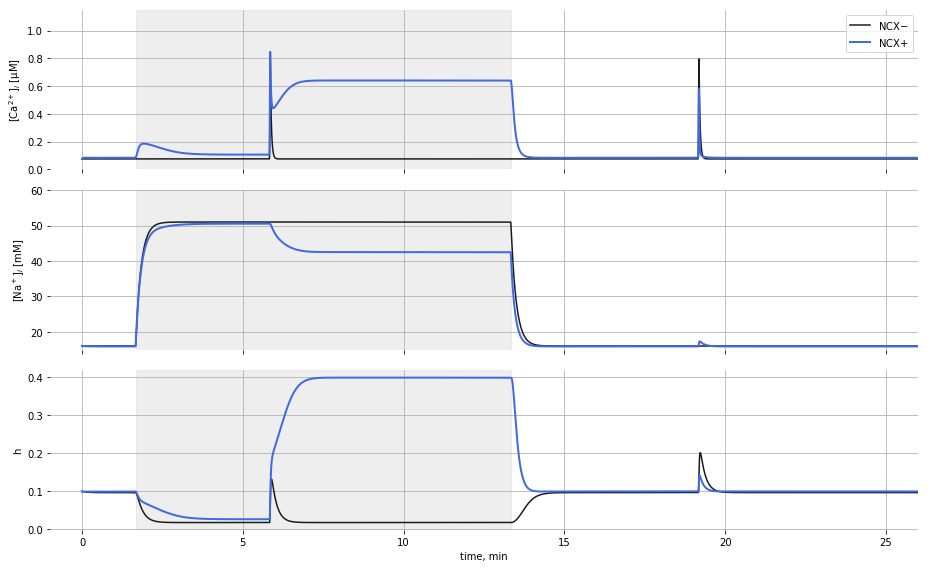

In [33]:
color0=(0.1,)*3
color='royalblue'

f,axs = subplots(3,1,sharex=True,figsize=(13,8))


axs[0].plot(tv0/60, traj0[:,0],color=color0,label='NCX$-$')
axs[0].plot(tv1/60, traj1[:,0],color=color, lw=2, label='NCX$+$')
axs[0].legend()
axs[0].set_ylabel('$[\mathrm{Ca}^{2+}]_i$ [μM]')
setp(axs[0],ylim=(0,1.15))


axs[1].plot(tv0/60, traj0[:,1],color=color0)
axs[1].plot(tv1/60, traj1[:,1],color=color,lw=2)
setp(axs[1],ylim=(15,60),ylabel='$[\mathrm{Na}^+]_i$ [mM]')

axs[2].plot(tv1/60, traj0[:,2],color=color0)
axs[2].plot(tv1/60, traj1[:,2],color=color,lw=2)
setp(axs[2],ylabel='h')

legend(loc=1)
xlabel('time, min')
xlim(-1,26)

for k,ax in enumerate(axs):
    ax.axvspan(100/60,800/60, color=(0.75,0.75,0.75),alpha=0.25, zorder=-20)
    simpleaxis(ax, 2 if k<2 else 1)
    ax.legend()
    
tight_layout()

We see that a Ca transient is amplified by the NCX when [Na] is high and is attenuated with [Na] is low.

The difference between the Ca dynamics with and without NCX is shown below.

Text(0.5,1,'Difference [Ca](uM) with NCX - no NCX')

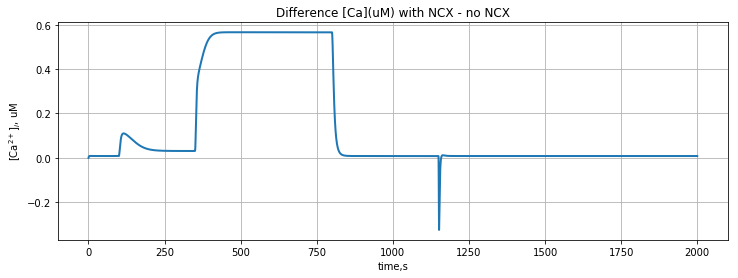

In [34]:
figure(figsize=(12,4))
plot(tv0, traj1[:,0]-traj0[:,0],lw=2)
xlabel('time,s')
ylabel('$[\mathrm{Ca}^{2+}]_i$, uM')
#ylim(.1,0.12)
title('Difference [Ca](uM) with NCX - no NCX')

## Regenerative Ca wave in a distributed model

In [22]:
def plot_distributed(var='Ca',idx=(50,60,80),jnarange=(100,800),ax=None, hx=0.5,):
    titles=dict(ca=(0,'$[\mathrm{Ca}^{2+}]_i$, μM'),
                na=(1,'$[\mathrm{Na}^+]_i$, μM'),
                h=(2,'$h$'))
    if ax is None:
        _,ax = subplots(1,1,figsize=(8,5))
    
    ax.axvspan(jnarange[0]/60,jnarange[1]/60, color=(0.75,0.75,0.75),alpha=0.25, zorder=-20)
    k,title_ = titles[var.lower()]
    for i in idx:
        ieff =  (i-idx[0])*hx
        ax.plot(tvx/60,trajx[:,k,i],label='x=%1.0f μm'%ieff)
    ax.set_xlabel('time, min'); ax.set_title(title_)
    setp(ax, xlabel='time, min', title=title_,ylabel=title_)
    ax.legend()
    simpleaxis(ax,1)

In [23]:
#@jit
def distributed_ncx(state,t,N=100, jna=lambda t:0, jca=lambda t:0, 
                    hx = 1.0, # spatial scale
                    D = 0.5,  # diffusion coefficient
                    na_flux_mask = ones(100), ca_flux_mask=ones(100),
                    tau_ex=2.0,r=1.,Jmax=0.5,V=Vastro,p=ncx_pars):
    "Simple NCX model with [Ca]i,[Na]i and h (inactivation) as variables, 1D distributed"
    ccai,cnai, h = state
    dna = zeros(N)
    dca = zeros(N)
    dh = zeros(N)
    D_eff = D/hx/hx
    for i in arange(1,N-1):
        jx = Jncx(ccai[i],cnai[i],h[i],Jmax=Jmax,V=V)
        dna[i] =  (cyt['Na']-cnai[i])/(5*tau_ex) - 3*jx
        dca[i] =  jx + (cyt['Ca']-ccai[i])/(tau_ex)
        dh[i] = (hinf(cnai[i],ccai[i])-h[i])/htau(ccai[i])
        
        dca[i] += D_eff*(ccai[i+1]+ccai[i-1]-2*ccai[i])
        dna[i] += D_eff*(cnai[i+1]+cnai[i-1]-2*cnai[i])
        
        if na_flux_mask[i]:
            dna[i] += jna(t)
        if ca_flux_mask[i]:
            dca[i] += jca(t)
    
    return array([dca,dna,dh])

In [24]:
N=60
init_st_d = array([cyt['Ca']*ones(N), cyt['Na']*ones(N), 0.01*ones(N)])
na_flux_mask = ones(N,bool)
na_flux_mask[:2] = na_flux_mask[-2:]= 0
ca_flux_mask = zeros(N,bool); ca_flux_mask[N//2] = True

In [25]:
ncx_p_d = ncx_p.copy()
ncx_p_d['ca_flux_mask'] = ca_flux_mask
ncx_p_d['N'] = N
ncx_p_d['D'] = 2.0  # Ca diffusion coefficient, μm^2/s
ncx_p_d['hx'] = 0.5 # μm/px
ncx_p_d['Jmax'] = 48

In [26]:
ncx_p_d['jca'] = make_pulses(arange(0,10000,0.2), 2, period=800, start=300,amp=5.6,width=2,steep=5.,base=0.)

In [27]:
%%time
tvx, trajx = adams_bashforth(distributed_ncx, init_st_d, dt=0.02,tstop=1400, fnkwargs=ncx_p_d )

CPU times: user 1min 51s, sys: 73.6 ms, total: 1min 51s
Wall time: 1min 51s


### Make the paper Figure

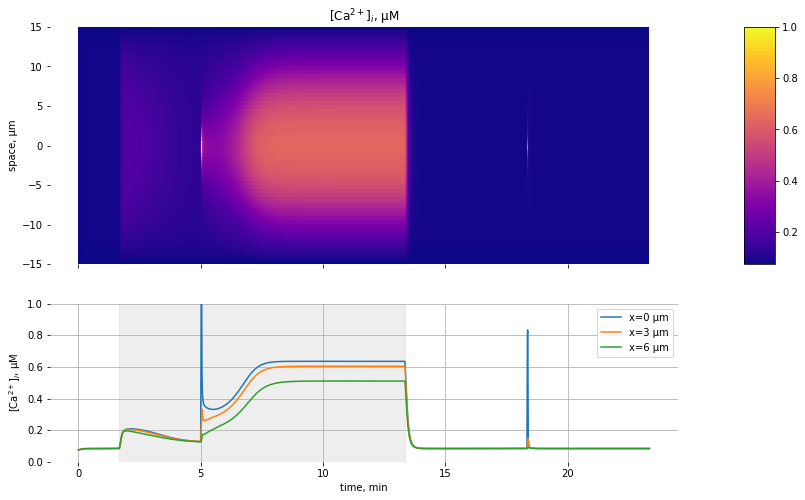

In [28]:
f,axs = subplots(2,2,sharex='col',gridspec_kw=dict(width_ratios=(20,1),height_ratios=(1.5,1)),figsize=(13,8))

m = axs[0,0].imshow(trajx[::100,0].T,aspect='auto',
                    cmap=cm.plasma,
                    vmax=1.0,
                    extent=(tvx[0]/60,tvx[-1]/60,-N*ncx_p_d['hx']/2,N*ncx_p_d['hx']/2)); 
colorbar(m,cax=axs[0,1])
#xlabel('time, min')

axs[0,0].set_ylabel(u'space, μm')

axs[0,0].grid(False)

plot_distributed('Ca', idx=(30, 36, 42),ax=axs[1,0])
axs[0,0].set_title(axs[1,0].get_title())
axs[1,0].set_title('')
axs[1,0].set_ylim(0,1)


setp(axs[1,1],visible=False)
simpleaxis(axs[1,0],)
simpleaxis(axs[0,0],2)

### Plot variables in several spatial locations

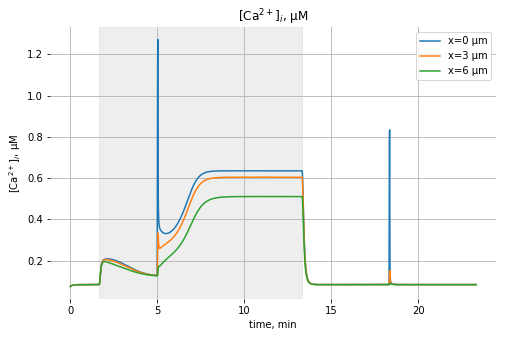

In [29]:
plot_distributed('Ca',idx=(30, 36, 42))

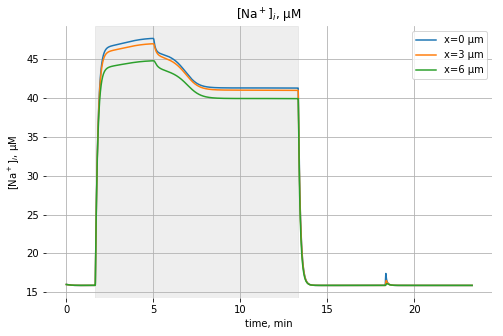

In [30]:
plot_distributed('Na',idx=(30, 36, 42))

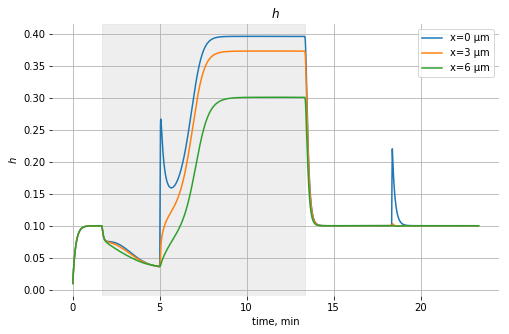

In [31]:
plot_distributed('h',idx=(30, 36, 42))